# Entrance Challenge: When Will the Sakura Bloom?

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In [1]:
#%matplotlib inline
names=['serial' ,'year' ,'month' ,'day' ,'local_pressure' ,'sea_pressure' ,
    'total_preci' ,'hr1_preci' ,'min10_preci' ,'avg_temp' ,'max_temp' ,'min_temp' ,
       'avg_humid' ,'min_humid' ,'sun_hours' ,'bloom']

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

### Importing Libraries

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

### Getting Data Ready

In [3]:
data_df=pd.read_csv('sakura.csv')
test_years= [1966, 1971, 1985, 1994,2008]
years=data_df['year'].unique()
train_years=[]
for year in years:
    if year not in test_years:
        train_years.append(year)

def get_yearly_dfs(df,year):
    year_gp=data_df.groupby('year')
    year_dfs={}
    for year in years:
        df=year_gp.get_group(year)
        df=df.reset_index()
        year_dfs[year]=df
    return year_dfs

In [4]:
def get_day_counts(yearly_dfs):
    yr_dfs=yearly_dfs.copy()
    for year in years:
        df=yr_dfs[year]
        ind=df.index.values.copy()
        ind+=1
        df['days']=ind
        yr_dfs[year]=df
    return yr_dfs
def get_acc_temps(yearly_dfs):
    yr_dfs=yearly_dfs.copy()
    for year in years:
        df=yr_dfs[year]
        acc_temp=0
        df['acc_temp']=0
        for row in range(len(df)):
            df_row=df.loc[row].copy()
            if df_row['month']>=2 and df_row['month']<=5:
                acc_temp+=df_row['max temp']
                df_row['acc_temp']=acc_temp
                df.loc[row]=df_row
        yr_dfs[year]=df
    return yr_dfs
#yearly_dfs=get_day_counts(yearly_dfs)
#yearly_dfs=get_acc_temps(yearly_dfs)

In [5]:
yearly_dfs=get_yearly_dfs(data_df,years)
yearly_dfs=get_day_counts(yearly_dfs)
yearly_dfs=get_acc_temps(yearly_dfs)

In [6]:
yearly_dfs[1962].loc[28:35]

,index,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom,days,acc_temp
28,393.0,393.0,1962.0,1.0,29.0,1010.3,1011.0,0.0,0.0,0.0,4.4,10.8,-1.2,44.0,23.0,6.3,0.0,29.0,0.0
29,394.0,394.0,1962.0,1.0,30.0,1009.1,1009.7,0.0,0.0,0.0,4.0,10.0,-1.5,38.0,14.0,9.4,0.0,30.0,0.0
30,395.0,395.0,1962.0,1.0,31.0,1013.7,1014.4,0.0,0.0,0.0,5.0,11.3,-1.8,37.0,24.0,9.5,0.0,31.0,0.0
31,396.0,396.0,1962.0,2.0,1.0,1020.8,1021.5,0.0,0.0,0.0,5.4,11.5,0.5,44.0,24.0,9.0,0.0,32.0,11.5
32,397.0,397.0,1962.0,2.0,2.0,1022.4,1023.1,0.0,0.0,0.0,5.3,11.2,-0.1,44.0,24.0,9.4,0.0,33.0,22.7
33,398.0,398.0,1962.0,2.0,3.0,1021.0,1021.7,0.0,0.0,0.0,4.5,10.0,-0.3,47.0,29.0,8.7,0.0,34.0,32.7
34,399.0,399.0,1962.0,2.0,4.0,1022.8,1023.5,0.0,0.0,0.0,4.6,10.9,-1.1,48.0,26.0,9.1,0.0,35.0,43.6
35,400.0,400.0,1962.0,2.0,5.0,1020.5,1021.3,0.0,0.0,0.0,5.2,10.9,0.0,56.0,31.0,6.4,0.0,36.0,54.5


### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [7]:
def get_true_label(year_dfs,yrs):
    true_lb=[]
    acc_df=[]
    for year in yrs:
        df=year_dfs[year].copy()
        ind= (df['bloom']==1)
        ind=np.argmax(np.array(ind))
        acc_df.append(df.loc[ind,'acc_temp'])
        true_lb.append(df.loc[ind,'days'])              
        
    acc_df =pd.DataFrame(acc_df,index=yrs,columns=['temp'])
    true_lb=pd.DataFrame(true_lb,index=yrs,columns=['true_days'])
    return acc_df,true_lb


acc_df,_=get_true_label(yearly_dfs,train_years)
print('Mean accumulated temperature\n',acc_df.mean(),'\n')
thr_temp=acc_df.mean()
# temp    615.776923
#dtype: float64 
#days    85.711538

Mean accumulated temperature
 temp    638.355769
dtype: float64 



In [8]:
def predict(yearly_dfs,yrs,thr_temp):
    
    pred_lb=[]
    for year in yrs:
        _df=yearly_dfs[year]
        for i in range(len(_df)):
            if (_df.loc[i,'acc_temp']>thr_temp):
                pred_lb.append(_df.loc[i,'days'])
                break
    pred_lb=pd.DataFrame(pred_lb,index=yrs,columns=['pred_days'])
    return pred_lb       
_,true_lb=get_true_label(yearly_dfs,test_years)     
pred_lb_mean=predict(yearly_dfs,test_years,float(thr_temp))
pred_lb_600=predict(yearly_dfs,test_years,float(600))


In [9]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
#lbs=pd.concat([true_lb,pred_lb],axis=1)
true_lb=np.array(true_lb)
pred_lb_mean=np.array(pred_lb_mean)
pred_lb_600=np.array(pred_lb_600)
err_mean=np.square(np.array(true_lb)-np.array(pred_lb_mean))
err_600=np.square(np.array(true_lb)-np.array(pred_lb_600))
r2_1=r2_score(true_lb,pred_lb_mean)
r2_2=r2_score(true_lb,pred_lb_600)
print('error_mean',np.mean(err_mean),'\nerror_600',np.mean(err_600))
print('r2_score\n',r2_1,'\n',r2_2)
#error_mean 2.923076923076923 
#error_600 3.269230769230769
#error_mean 2.2 
#error_600 2.4

error_mean 4.6 
error_600 8.8
r2_score
 0.8323615160349854 
 0.6793002915451896


***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

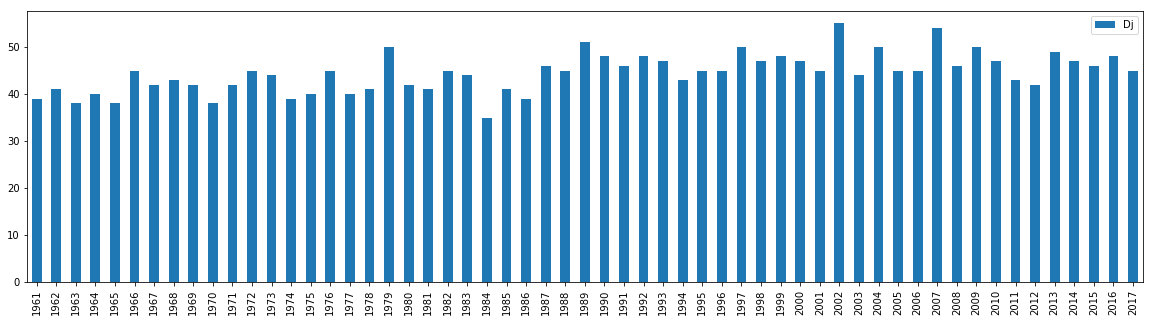

In [10]:
def get_Djs(yerly_dfs,years):
    Fi=35.67
    L=4
    Djs=[]
    for year in years:
        _df=yearly_dfs[year]
        Tf=_df[_df['month']<=3]['avg temp'].mean()
        𝐷j=136.75- 7.689*Fi+ 0.133*(Fi**2)- 1.307*np.log(L)+ 0.144*Tf+ 0.285*(Tf**2)
        Djs.append(int(Dj))
        
    Dj_df=pd.DataFrame(Djs,index=years,columns=['Dj'])
    return Dj_df
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
Dj_df=get_Djs(yearly_dfs,years)
Dj_df.plot.bar(ax=axes)
#Dj_df.plot(ax=axes)
plt.show()

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


In [11]:
def get_ts(Ea,Tj):
        R=8.314
        Ts=17
        A=Ea*(Tj-Ts)*4184
        B=R*(Tj+273)*(Ts+273)
        C=A/B
        return np.exp(C)

_,Bdj_df=get_true_label(yearly_dfs,years)

def get_dts(yearly_dfs,Ea,yrs):
    DTS_df=[]
    for year in yrs:
        _df=yearly_dfs[year]
        
        Dj=Dj_df.loc[year,'Dj']
        Bdj=Bdj_df.loc[year,'true_days']
        
        indx=_df['days']>=int(Dj) 
        indx&=_df['days']<=int(Bdj)
        Tjs=_df[indx]['avg temp']
        
        DTS=0
        for Tj in Tjs:
            DTS+=get_ts(Ea,Tj)
        DTS_df.append(DTS)
    DTS_df=pd.DataFrame(DTS_df,index=yrs,columns=['Ea_'+str(Ea)])
    return DTS_df

DTS_df=get_dts(yearly_dfs,5,train_years)
#Eas=list([0.001,0.002,0.003])
Eas=list(range(6,41))
for Ea in Eas:
    DTS_df=pd.concat([DTS_df,get_dts(yearly_dfs,Ea,train_years)],axis=1)

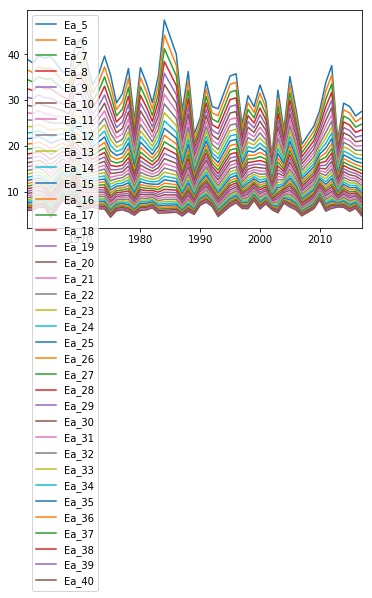

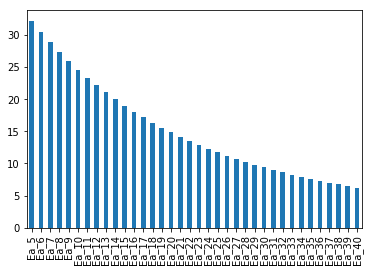

Ea_5     32.207353
Ea_6     30.487368
Ea_7     28.871963
Ea_8     27.354288
Ea_9     25.927966
Ea_10    24.587061
Ea_11    23.326045
Ea_12    22.139768
Ea_13    21.023433
Ea_14    19.972567
Ea_15    18.983002
Ea_16    18.050851
Ea_17    17.172491
Ea_18    16.344539
Ea_19    15.563839
Ea_20    14.827447
Ea_21    14.132613
Ea_22    13.476768
Ea_23    12.857516
Ea_24    12.272614
Ea_25    11.719968
Ea_26    11.197622
Ea_27    10.703743
Ea_28    10.236621
Ea_29     9.794654
Ea_30     9.376342
Ea_31     8.980284
Ea_32     8.605165
Ea_33     8.249756
Ea_34     7.912905
Ea_35     7.593532
Ea_36     7.290625
Ea_37     7.003235
Ea_38     6.730474
Ea_39     6.471507
Ea_40     6.225551
dtype: float64

In [12]:
DTS_df.plot()
plt.show()
DTS_df.mean().plot.bar()
plt.show()
DTS_df.mean()

In [13]:
def predict_ts(yearly_dfs,Ea,yrs,DTS_mean):
    pred_df=[]
    for year in yrs: 
        _df=yearly_dfs[year]
        
        Dj=Dj_df.loc[year,'Dj']
        indx=_df['days']>=int(Dj) 
        Tjs=_df[indx]['avg temp']
    
        DTS=0
        ind=Dj-1
        for Tj in Tjs:
            DTS+=get_ts(Ea,Tj)
            if DTS>=DTS_mean['Ea_'+str(Ea)] or ind>=(len(_df)-1):
                pred_Bdj=_df.loc[ind,'days']
                break
            ind+=1
            
                
        pred_df.append(pred_Bdj)
    pred_df=pd.DataFrame(pred_df,index=yrs,columns=['Ea_'+str(Ea)])
    return pred_df

In [14]:
pred_df=predict_ts(yearly_dfs,5,train_years,DTS_df.mean())
#Eas=list([0.001,0.002,0.003])
Eas=list(range(6,40))
for Ea in Eas:
    pred_df=pd.concat([pred_df,predict_ts(yearly_dfs,Ea,train_years,DTS_df.mean())],axis=1)


### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

6 6.019230769230769
7 5.75
8 5.461538461538462
9 5.173076923076923
10 4.9423076923076925
11 4.673076923076923
12 4.423076923076923
13 4.173076923076923
14 3.9423076923076925
15 3.75
16 3.480769230769231
17 3.326923076923077
18 3.1153846153846154
19 2.9615384615384617
20 2.8076923076923075
21 2.8076923076923075
22 2.6153846153846154
23 2.5384615384615383
24 2.4423076923076925
25 2.4615384615384617
26 2.3653846153846154
27 2.269230769230769
28 2.25
29 2.3076923076923075
30 2.230769230769231
31 2.230769230769231
32 2.25
33 2.230769230769231
34 2.3461538461538463
35 2.3653846153846154
36 2.4423076923076925
37 2.5384615384615383
38 2.5384615384615383
39 2.5576923076923075


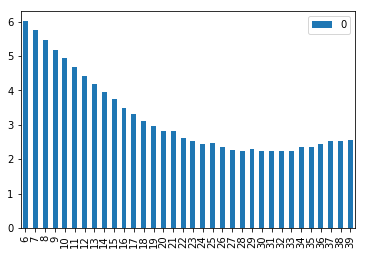

In [15]:
_,Bdj_df=get_true_label(yearly_dfs,train_years)
err_df=[]
#Eas=list(range(30,31))
#Eas=[0.001,0.002,0.003]
for Ea in Eas:
    
    err=0
    DTS=DTS_df.mean()['Ea_'+str(Ea)]
    for year in train_years:
        #DTS=DTS_df.loc[year,'Ea_'+str(Ea)]
        Dj=int(Dj_df.loc[year,'Dj'])
        pred_Bdj=pred_df.loc[year,'Ea_'+str(Ea)]
        true_Bdj=Bdj_df.loc[year,'true_days']
        #print(year,pred_Bdj)
        err+=np.abs(true_Bdj-pred_Bdj)
    err/=len(train_years)
    print(Ea,err)
    err_df.append(err)
        
err_df=pd.DataFrame(err_df,index=Eas)
err_df.plot.bar()

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [16]:
  
pred_df=predict_ts(yearly_dfs,30,test_years,DTS_df.mean())
_,Bdj_df=get_true_label(yearly_dfs,test_years)
err_df=[]
Ea=30
err=0

Bdj_df=np.array(Bdj_df)
pred_df=np.array(pred_df)
err=np.square(Bdj_df-pred_df)
err=np.mean(err)
r2_err=r2_score(Bdj_df,pred_df)
        
#err/=len(train_years)
print(Ea,err,r2_err)

30 0.8 0.9708454810495627


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1.According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.



2.There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

In [17]:
DTS_mean=DTS_df.mean()['Ea_'+str(30)]
Ea=30
def add_dts(yearly_dfs,Ea,yrs,DTS_mean):

    for year in yrs: 
        _df=yearly_dfs[year]
        
        Dj=Dj_df.loc[year,'Dj']
        indx=_df['days']>=int(Dj) 
        Tjs=_df[indx]['avg temp']
        _df['dts']=0
        _df['ts']=0
        _df['dj']=0
        DTS=0
        ind=int(Dj-1)
        print(year)
        
        for Tj in Tjs:
            df_row=_df.loc[ind].copy()
            TS=get_ts(Ea,Tj)
            DTS+=TS
            df_row['dts']=DTS
            df_row['dj']=Dj
            df_row['ts']=TS
            _df.loc[ind]=df_row
            if ind>=(len(_df)-1):
                break
            ind+=1
        yearly_dfs[year]=_df
    return yearly_dfs
yearly_dfs=add_dts(yearly_dfs,Ea,years,DTS_mean)

1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

In [18]:
def get_nn_dfs(yearly_dfs,yrs):
    nn_dfs={}
    for year in yrs:
        _df=yearly_dfs[year].copy()
        Dj=Dj_df.loc[year,'Dj']
        ind1=int(Dj-1)
        ind2=ind1+60#Ind_2.loc[year].values[0]-1
        df=_df.loc[ind1:ind2,:].copy()
        nn_dfs[year]=df
    return nn_dfs
nn_dfs=get_nn_dfs(yearly_dfs,years)

In [141]:
tr_years=[]
val_years=[]
for year in train_years:
    if year%5==0:
        val_years.append(year)
    else :
        tr_years.append(year)
print(len(tr_years),len(val_years))
tr_years=tr_years[:-1]

42 10


In [142]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler


feats= [ 
'year','local pressure','sea pressure',
'total preci','hr1 preci','min10 preci',
'avg temp','max temp','min temp','avg humid',
'min humid','sun hours','dts','acc_temp'
]
#feats=['dts','hr1 preci','sun hours','year']
feats=['max_temp_2','max_temp_3','hr1 preci','sun hours']#'local pressure','avg humid','year']

for year in years:
    nn_df=nn_dfs[year].copy()
    _df=yearly_dfs[year].copy()
    yr_gp=nn_df.groupby('month')
    feb=yr_gp.get_group(2).reset_index()
    mrch=yr_gp.get_group(3).reset_index()
    nn_df['max_temp_1']=_df.groupby('month').get_group(1)['avg temp'].mean()
    nn_df['max_temp_2']=feb['max temp'].mean()
    nn_df['max_temp_3']=mrch['max temp'].mean()
    nn_dfs[year]=nn_df

def get_arrays(dfs,yrs):
    _,Bdj_df=get_true_label(yearly_dfs,yrs)
    _X=[]
    _Y=[]
    for year in yrs:
        df=dfs[year]
        _X.append(df[feats].mean())
        _Y.append(Bdj_df.loc[year])
    _X=np.array(_X)
    _Y=np.array(_Y)#-Dj_df.loc[year,'Dj'])

    scalar= RobustScaler()
    #scalar= MinMaxScaler()
    _X=scalar.fit(_X).transform(_X)
    _df=pd.DataFrame(_X,columns=feats)
    _df['days']=_Y
    return _X,_Y,_df
trainX,trainY,train_df=get_arrays(nn_dfs,tr_years)
testX,testY,test_df=get_arrays(nn_dfs,test_years)
valX,valY,val_df=get_arrays(nn_dfs,val_years)

In [143]:
import seaborn as sns
corrmat = train_df.corr()
sns.heatmap(corrmat)
corrmat['corr_value']=corrmat['days'].abs()
_corrmat=corrmat.sort_values( by=['corr_value'],ascending=False)
cm=(_corrmat['corr_value'].abs())
cm=pd.DataFrame(cm)
corr_cols=list(cm.index)
corr_cols=corr_cols[1:]
print(corr_cols)
cm

['max_temp_3', 'max_temp_2', 'hr1 preci', 'sun hours']


,corr_value
days,1.000000
max_temp_3,0.790167
max_temp_2,0.651705
hr1 preci,0.517822
sun hours,0.085417


In [144]:
#%matplotlib inline
#trainX[trainX[:,0]>2.0]=1.7
n=int(len(feats)/2)
train_df=pd.DataFrame(trainX,columns=feats)
train_df['days']=trainY
fig, axes = plt.subplots(nrows=2, ncols=n,figsize=(15,8))
for i in range(0,n):
    train_df.plot.scatter(x=feats[i],y='days',ax=axes[0,i])#;axes[0,i].set_title(feats[i]);
    
for i in range(0,n):
    train_df.plot.scatter(x=feats[i+n],y='days',ax=axes[1,i])#;axes[1,i].set_title(feats[i+3]);
plt.show()
    

In [156]:
#%matplotlib inline
feat='max_temp_2'
outliers=(train_df[feat]<-0.0) & (train_df['days']<78)
#outliers|=(train_df['dts']>2.5)

plt.scatter(train_df.loc[:,feats[0]],train_df.loc[:,'days'],marker='*',color='b')
#plt.scatter(train_df.loc[45:,feats[0]],train_df.loc[45:,'days'],marker='*',color='g')
plt.scatter(val_df.loc[:,feats[0]],val_df.loc[:,'days'],marker='*',color='g')
plt.scatter(train_df.loc[outliers,feats[0]],train_df.loc[outliers,'days'],marker='*',color='r')
plt.show()

In [146]:
print(trainX.shape,trainY.shape)
print(valX.shape,valY.shape)
print(testX.shape,testY.shape)

(41, 4) (41, 1)
(10, 4) (10, 1)
(5, 4) (5, 1)


In [147]:
n_hidden_1 = 1
n_input = trainX.shape[1]
n_classes = 1#_train_y.shape[1]

class ANN():
    def __init__(self):
            init_zero=tf.zeros_initializer()
            init_glorot=tf.glorot_uniform_initializer()
            init_trunc_normal=tf.truncated_normal_initializer(stddev=1e-3)
            init_rand_norm=tf.random_normal_initializer(stddev=1e-3)
            with tf.variable_scope("weights", reuse=tf.AUTO_REUSE):
                    self.w1= tf.get_variable('w1',[n_input, n_hidden_1],dtype=tf.float64,initializer=init_glorot)
            with tf.variable_scope("biases", reuse=tf.AUTO_REUSE):
                    self.b1= tf.get_variable('b1',[n_hidden_1],dtype=tf.float64,initializer=init_zero)
            self.weights=[self.w1]
            self.biases = [self.b1]
    def model_predict(self,x):
        out = tf.add(tf.matmul(x, self.weights[0]),self.biases[0])
        out = tf.nn.relu(out)
        return out
    
    def loss_func(self,y,out):
        _loss = tf.losses.mean_squared_error(labels=y, predictions=out)
        loss=tf.cast(_loss,tf.float64)
        return loss
    def reg_loss_func(self,loss,beta):
        beta=np.float64(beta)

        reg_w1=0.5*tf.reduce_sum(tf.square(self.weights[0]))
        _reg=reg_w1

        reg=tf.cast(_reg,tf.float64)
        reg=tf.multiply(beta,reg)
        reg_loss=0.5*tf.add(loss,reg)
        
        return reg_loss
    def opt_func(self,lr,loss):
        trainable_vars=[self.w1,self.b1]
        #tf.GraphKeys.TRAINABLE_VARIABLE
        optimizer = tf.train.RMSPropOptimizer(lr)
        grads_and_vars=optimizer.compute_gradients(loss,trainable_vars)
        train_op=optimizer.apply_gradients(grads_and_vars)
        #train_op = optimizer.minimize(loss)
        return train_op
    
    def get_weights(self):
        return self.weights,self.biases
    
    def set_weights(self,wts,bias):
        self.weights[0]=tf.convert_to_tensor(wts[0])
        self.biases[0]=tf.convert_to_tensor(bias[0])
        self.weights[1]=tf.convert_to_tensor(wts[1])
        self.biases[1]=tf.convert_to_tensor(bias[1])
        

In [148]:
epoc=500
#epoc=1000
lr=0.1
beta=5
no_of_batch=4 #(For Batch size of about 14-15)
xx=np.array_split(trainX,no_of_batch)
yy=np.array_split(trainY,no_of_batch)
xx_val=np.array_split(valX,no_of_batch)
yy_val=np.array_split(valY,no_of_batch)

In [149]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder(tf.float64, shape=[None, trainX.shape[1]])
y=tf.placeholder(tf.float64, shape=[None, 1])

M=ANN()
out=M.model_predict(x)
loss=M.loss_func(y,out)

reg_loss=M.reg_loss_func(loss,beta)
train_op=M.opt_func(lr,loss)

In [150]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#%matplotlib notebook
from IPython.display import clear_output


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

t_loss=[]
v_loss=[]

#fig = plt.figure()
#ax = fig.add_subplot(111)
#plt.ion()
#fig.show()

for i in range(epoc+1):
    train_loss=0
    
    for j in range(0,len(xx)):
        inputs_train={x:xx[j],y:yy[j]}
        _= sess.run((train_op),feed_dict=inputs_train)
        loss_train = sess.run((loss),feed_dict=inputs_train)
        train_loss+=loss_train
    train_loss/=(j+1)
        
    val_loss=0
    for k in range(0,len(xx_val)):
        inputs_valid={x:xx_val[k],y:yy_val[k]}
        loss_valid = sess.run((loss),feed_dict=inputs_valid)
        val_loss+=loss_valid
        
    val_loss/=(k+1)
    t_loss.append(train_loss)
    v_loss.append(val_loss)
    
    disp_log=50
    if i>disp_log and i%disp_log==0:
        #clear_output()
        mt_loss=np.mean(np.array(t_loss[i-disp_log:i]))
        mv_loss=np.mean(np.array(v_loss[i-disp_log:i]))
        print('epoc:',i-disp_log,'-',i,'mean_train_loss:',mt_loss,'mean_valid_loss:',mv_loss)
    if i>30000:
        ax.clear()
        ax.plot(t_loss[-300:])
        ax.plot(v_loss[-300:])
        fig.canvas.draw()

epoc: 50 - 100 mean_train_loss: 3314.5939996337893 mean_valid_loss: 3949.130191574097
epoc: 100 - 150 mean_train_loss: 1474.5406071472169 mean_valid_loss: 1839.9078672027588
epoc: 150 - 200 mean_train_loss: 360.295301361084 mean_valid_loss: 433.0614212799072
epoc: 200 - 250 mean_train_loss: 20.961421270370483 mean_valid_loss: 29.34718178868294
epoc: 250 - 300 mean_train_loss: 7.438168087005615 mean_valid_loss: 12.734978985786437
epoc: 300 - 350 mean_train_loss: 7.438009362220765 mean_valid_loss: 12.741968638896942
epoc: 350 - 400 mean_train_loss: 7.438010921478272 mean_valid_loss: 12.741965942382812
epoc: 400 - 450 mean_train_loss: 7.438011014461518 mean_valid_loss: 12.741964931488036
epoc: 450 - 500 mean_train_loss: 7.438011076450348 mean_valid_loss: 12.741964931488036


***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

In [151]:
%matplotlib tk
loss_df=pd.DataFrame(np.array([t_loss,v_loss]).T,columns=['train_loss','val_loss'])
loss_df.loc[200:].plot()
plt.show()

In [152]:
def predict_runtime(test_data):
    inputs_test={x:np.array(test_data)}
    res = sess.run((out),feed_dict=inputs_test)
    res = res.reshape(-1)
    return res
pred_trainY=predict_runtime(trainX)
pred_valY=predict_runtime(valX)
pred_testY=predict_runtime(testX)

In [153]:
tr_err=mean_squared_error(trainY,pred_trainY)
val_er=mean_squared_error(valY,pred_valY)
test_er=mean_squared_error(testY,pred_testY)
tr_r2=r2_score(trainY,pred_trainY)
val_r2=r2_score(valY,pred_valY)
test_r2=r2_score(testY,pred_testY)

print('#',[tr_err,val_er,test_er])
print('#',[tr_r2,val_r2,test_r2])

# [8.450787840298778, 11.574450802675923, 3.5421122734592045]
# [0.7414425749215403, 0.5523265147251951, 0.8709142757485713]
# [9.023735578193186, 10.086662477149202, 7.016579495931306]
# [0.72391286117011, 0.6098707901637956, 0.744293750148276]
# [13.164607969794053, 40.516895716042, 3.4677653137305144]
# [0.5972201405168661, -0.5671015607516245, 0.8736237130564681]
# [9.457840718517378, 13.005036115906057, 3.3943191526123746]
# [0.7106311282220517, 0.4969947219624129, 0.8763003224266627]
#'dts':[0.7106311282220517, 0.4969947219624129, 0.8763003224266627]
#'dts': [0.752873215308781, 0.15774853655244236, 0.9761094135972783]
#'dts+max_temp+others':[0.7911262453496621, 0.7372251372057042, 0.983810007923285]

#dts+max_temp+others
# [6.826908124649637, 6.793957698266361, 0.4442533825850613]
# [0.7911262453496621, 0.7372251372057042, 0.983810007923285]


#dts+max_temp
# [7.805944677876136, 7.131829265457432, 1.335809119965464]
# [0.7611719765828125, 0.7241570318900967, 0.9513189096222499]
prep_df={
'dts': [0.7106311245877542, 0.4969946748045254, 0.8763002694186173],
'max_emp':[0.7296087264537421, 0.7046040905481057, 0.9569788778819649],
'hr1_prec': [0.7591587512336456, 0.811751605188515, 0.9856135112026704],
'sun hours': [0.759386215370855, 0.8096674309046803, 0.9882611802446091],
}
prep_df=pd.DataFrame(prep_df,index=['train','val','test']).transpose()
#prep_df.plot.bar()

# [7.785399403554869, 12.60762449994217, 1.0299350088533792]
# [0.7740927915940113, 0.5560695598611911, 0.9624659253333316]


In [ ]:

#loss: 8.3634 - acc: 0.1961 - val_loss: 88.6133 -
#dts_2000_0.01_lr-1
Dj_df={
'Dj-Dj+60':[0.848715625702062,0.741363303453404],
'Dj-Dj+75':[0.797084417597424,0.708412112037132],
'Dj-Dj+45':[0.7962881777773756,0.7479627828657656],
'30-90':[0.6023504754927881,0.599869050027288],
'0-90':[0.6082100939263051,0.5998106089606232],
'0-120':[0.6455204116232051,0.4675871879565794]

}

Dj_df=pd.DataFrame(Dj_df,index=['test','train']).transpose()
Dj_df.plot.bar()
Dj_df

In [ ]:
import pickle
def save_weights(model):
    wts,bias=model.get_weights()
    wt,bs=sess.run((wts,bias))

    f=open("trained_params","wb")
    pickle.dump([wt,bs],f)
    f.close()
def load_weights():
    f=open("trained_params","rb")
    [wt,bs]=pickle.load(f)
    f.close()
    return wt,bs
def build_and_predict(test_data,wt,bs):
    tf.reset_default_graph()

    N=ANN()
    N.set_weights(wt,bs)
    tx = tf.placeholder(tf.float64, shape=[None, _trainX.shape[1]])
    t_out=N.model_predict(tx)

    t_sess = tf.Session()
    init = tf.global_variables_initializer()
    t_sess.run(init)

    inputs_test={tx:np.array(test_data)}
    res = t_sess.run((t_out),feed_dict=inputs_test)
    res = res.reshape(-1)
    return res

In [ ]:
#save_weights(model=M)
wt,bs=load_weights()
res=build_and_predict(valX,wt,bs)
r2_score(valY,res)